Part 1: Data Quality Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [7]:
# =========================
# Import CSV Data
# =========================
df_users = pd.read_csv("USER_TAKEHOME.csv")
df_transactions = pd.read_csv("TRANSACTION_TAKEHOME.csv")
df_products = pd.read_csv("PRODUCTS_TAKEHOME.csv")

# Convert all column names to lower case for ease of use
df_users.columns = df_users.columns.str.lower()
df_transactions.columns = df_transactions.columns.str.lower()
df_products.columns = df_products.columns.str.lower()

print('df_users:', df_users.shape)
print('df_transactions:', df_transactions.shape)
print('df_products:', df_products.shape)

df_users: (100000, 6)
df_transactions: (50000, 8)
df_products: (845552, 7)


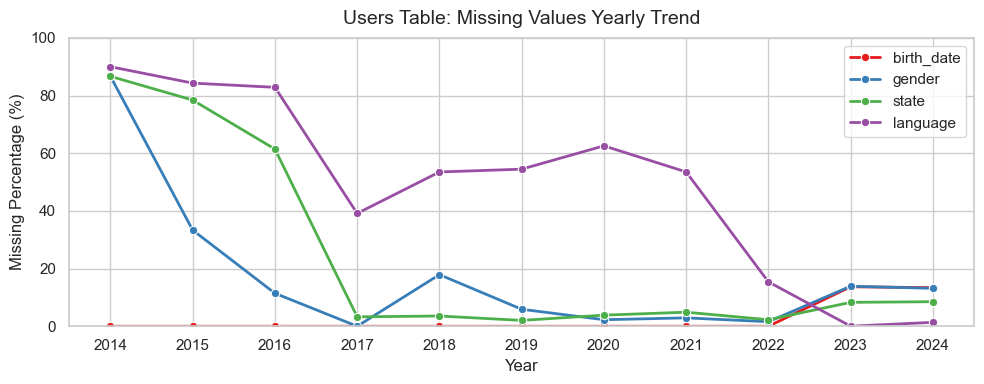

year,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
birth_date,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005219,0.003730,13.696327,13.369444
gender,86.666667,33.333333,11.428571,0.000000,17.896679,5.893134,2.262631,2.907250,1.570485,13.870926,13.154501
state,86.666667,78.431373,61.428571,3.260870,3.551661,2.030171,3.850027,4.874993,2.256873,8.290222,8.511736
language,90.000000,84.313725,82.857143,39.130435,53.505535,54.476244,62.565895,53.515319,15.395233,0.019400,1.358439


In [164]:
# =========================
# Analysis 1: Users Table 
# =========================

# Convert created_date to datetime to extract year
df_users['created_date'] = pd.to_datetime(df_users['created_date'], errors='coerce')
df_users['year'] = df_users['created_date'].dt.year

# Computing missing percentage by year
user_fields = ['birth_date', 'gender', 'state', 'language']
missing_users = df_users.groupby('year')[user_fields].apply(lambda x: x.isnull().mean() * 100).reset_index()

# Melt the DataFrame so each row corresponds to (year, field, missing_pct)
df_melted = missing_users.melt(id_vars='year', var_name='field', value_name='missing_pct')

# Plotting through seaborn
sns.set_style("whitegrid")
sns.set_palette("Set1")
plt.figure(figsize=(10, 4))

sns.lineplot(data=df_melted, x='year', y='missing_pct', hue='field', marker='o', linewidth=2)

plt.title("Users Table: Missing Values Yearly Trend", fontsize=14, pad=10)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Missing Percentage (%)", fontsize=12)
plt.ylim(0, 100)  
plt.xticks(df_melted['year'].unique())  
plt.legend(loc='best')
plt.tight_layout()
plt.show()

#Output data table as well
missing_users.set_index('year').T



In [165]:
# =========================
# Analysis 2: Products Table 
# =========================

# Check missing values in barcode column 
missing_barcode_pct = df_products['barcode'].isnull().mean() * 100
print(f"Products Table - Missing Barcode Percentage: {missing_barcode_pct:.2f}%")

# Check duplicate barcode values across products 
duplicate_barcode_pct = (df_products[df_products['barcode'].notnull()]['barcode'].duplicated(keep='first').mean() * 100)
print(f"Products Table - Duplicate Barcode Percentage: {duplicate_barcode_pct:.2f}%")

# Absolute counts from table
products_summary = {
    "Total Products": len(df_products),
    "Missing Barcodes": df_products['barcode'].isnull().sum(),
    "Duplicate Barcodes": df_products[df_products['barcode'].notnull()]['barcode'].duplicated(keep='first').sum()
}
print("\nProducts Table Summary:")
print(products_summary)

#Example cases:
#df_products[df_products['barcode'].isnull()].head(2)   #null barcodes
#df_products[df_products['barcode'] == 3498507.0]       #duplicate entry
#df_products[df_products['barcode'] == 20159078.0]      #overlap: same barcode different products

Products Table - Missing Barcode Percentage: 0.48%
Products Table - Duplicate Barcode Percentage: 0.02%

Products Table Summary:
{'Total Products': 845552, 'Missing Barcodes': np.int64(4025), 'Duplicate Barcodes': np.int64(185)}


In [167]:
# =========================
# Analysis 3: Transactions Table 
# =========================


# Transactions where FINAL_QUANTITY equals 'zero'
pct_final_qty_zero = (df_transactions['final_quantity'] == 'zero').mean() * 100
print(f"Transactions Table - Percentage with final_quantity as 'zero': {pct_final_qty_zero:.2f}%")

daily_final_qty_zero = df_transactions.groupby(df_transactions['purchase_date'].dt.date)['final_quantity'].apply(lambda x: (x == 'zero').mean() * 100).reset_index(name='pct_final_qty_zero')
avg_final_qty_zero = daily_final_qty_zero['pct_final_qty_zero'].mean()
print(f"Transactions Table - Average daily percentage with final_quantity as 'zero': {avg_final_qty_zero:.2f}%")


# Transactions where FINAL_SALE is blank (empty string or NaN)
pct_final_sale_blank = (df_transactions['final_sale'] == ' ').mean() * 100
print(f"Transactions Table - Percentage with final_sale as blanks with whitespace: {pct_final_sale_blank:.2f}%")

# Transactions where FINAL_SALE is 0 
pct_final_sale_blank = (df_transactions['final_sale'] == '0.00').mean() * 100
print(f"Transactions Table - Percentage with final_sale as 0: {pct_final_sale_blank:.2f}%")

# Check overlap of quantity and sale conditions. No overlap for quantity = zero and sale = ' '. 159 cases for when sale = '0.00'
overlap_cases = len(df_transactions[(df_transactions['final_quantity'] == 'zero') & ((df_transactions['final_sale'] == '0.00') | (df_transactions['final_sale'] == ' '))])
print(f"Transactions Table - Overlap of above cases: {overlap_cases}")

# Overall duplicate records in transactions
dup_trans_pct = df_transactions.duplicated().mean() * 100
print(f"Transactions Table - Percentage of complete duplicates across all columns: {dup_trans_pct:.2f}%")

# Missing barcodes in transactions 
missing_barcode_trans = df_transactions['barcode'].isnull().mean() * 100
print(f"Transactions Table - Missing Barcode Percentage: {missing_barcode_trans:.2f}%")

df_transactions['purchase_date'] = pd.to_datetime(df_transactions['purchase_date'])
daily_missing = df_transactions.groupby(df_transactions['purchase_date'].dt.date)['barcode'].apply(lambda x: x.isnull().mean() * 100).reset_index(name='missing_barcode_pct')
daily_avg_missing = daily_missing['missing_barcode_pct'].mean()
print(f"Transactions Table - Average daily missing barcode percentage: {daily_avg_missing:.2f}%")

# Missing barcodes in transactions after removing suspected invalid rows from final_quantity and final_sale 
df_transactions_filtered = df_transactions[(df_transactions['final_quantity'] != 'zero') & (df_transactions['final_sale'] != ' ') & (df_transactions['final_sale'] != '0.00')]
missing_barcode_trans_2 = df_transactions_filtered['barcode'].isnull().mean() * 100
print(f"Transactions Table - Missing Barcode Percentage (after removing suspected invalid rows): {missing_barcode_trans_2:.2f}%")


#Example cases:
#df_transactions[(df_transactions['barcode'].isnull()) & (df_transactions['final_quantity'] != 'zero') & (df_transactions['final_sale'] != ' ')].head(2)   #null barcodes
# df_transactions[df_transactions['receipt_id'] == '2ae6a9f5-e5f2-46cb-9cc8-3e5cbe2d8a00'] # duplicates and null barcodes
# df_transactions[df_transactions['receipt_id'] == '000239aa-3478-453d-801e-66a82e39c8af'] # duplicate with final_quantity = 'zero'
# df_transactions[df_transactions['receipt_id'] == '0000d256-4041-4a3e-adc4-5623fb6e0c99'] # duplicate with final_sale = ' '
# df_transactions[df_transactions['receipt_id'] == 'b4922d65-77d4-4910-ae7d-02120d8d6fe7'] # duplicate with final_sale = '0.00'


Transactions Table - Percentage with final_quantity as 'zero': 25.00%
Transactions Table - Average daily percentage with final_quantity as 'zero': 24.98%
Transactions Table - Percentage with final_sale as blanks with whitespace: 25.00%
Transactions Table - Percentage with final_sale as 0: 0.96%
Transactions Table - Overlap of above cases: 159
Transactions Table - Percentage of complete duplicates across all columns: 0.34%
Transactions Table - Missing Barcode Percentage: 11.52%
Transactions Table - Average daily missing barcode percentage: 11.38%
Transactions Table - Missing Barcode Percentage (after removing suspected invalid rows): 10.84%


In [168]:
#Finding if final_quantity and final_sale inconsistencies are captured as duplicates

#Check duplicates across all columns except final_quantity and final_sale
subset_cols = ["receipt_id", "purchase_date", "scan_date", "store_name", "user_id", "barcode"]
duplicates = df_transactions[df_transactions.duplicated(subset=subset_cols, keep=False)]

# filter groups with at least one row where final_sale == ' ' or final_quantity == 'zero'
duplicates_with_blank = duplicates.groupby(subset_cols).filter(lambda group: ((group['final_sale'] == ' ') | (group['final_quantity'] == 'zero')).any())

# count only the invalidate rows
num_blank_rows = duplicates_with_blank[((duplicates_with_blank['final_sale'] == ' ') | (duplicates_with_blank['final_quantity'] == 'zero'))].shape[0]

# calculate the percentage relative to the entire dataset
pct_blank_rows = (num_blank_rows / df_transactions.shape[0]) * 100
print(f"Percentage of overall dataset that are rows with final_sale = ' ' or final_quantity = 'zero' among duplicate groups: {pct_blank_rows:.2f}%")


Percentage of overall dataset that are rows with final_sale = ' ' or final_quantity = 'zero' among duplicate groups: 44.24%


Average daily % with final_quantity = 'zero': 24.98%
Average daily missing barcode %: 11.38%


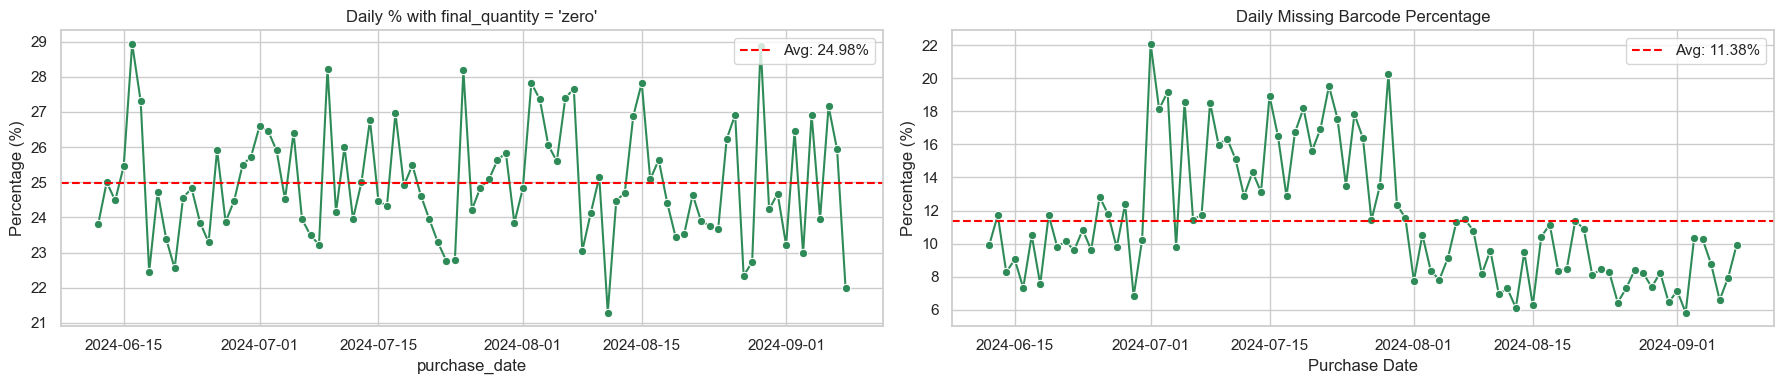

In [183]:
### Plotting Daily for missing/ invalid records to see if phenomenom occurs over time or is mostly consolidated at a specific period

# Ensure purchase_date is datetime
df_transactions['purchase_date'] = pd.to_datetime(df_transactions['purchase_date'])

# Compute daily percentage for final_quantity == 'zero'
daily_final_qty_zero = df_transactions.groupby(df_transactions['purchase_date'].dt.date)['final_quantity']\
    .apply(lambda x: (x == 'zero').mean() * 100).reset_index(name='pct_final_qty_zero')
avg_final_qty_zero = daily_final_qty_zero['pct_final_qty_zero'].mean()
print(f"Average daily % with final_quantity = 'zero': {avg_final_qty_zero:.2f}%")

# Compute daily percentage for missing barcode
daily_missing = df_transactions.groupby(df_transactions['purchase_date'].dt.date)['barcode']\
    .apply(lambda x: x.isnull().mean() * 100).reset_index(name='missing_barcode_pct')
daily_avg_missing = daily_missing['missing_barcode_pct'].mean()
print(f"Average daily missing barcode %: {daily_avg_missing:.2f}%")

# Plotting with seaborn
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(18, 4), sharex=True)

# Plot 1: Daily % with final_quantity == 'zero'
sns.lineplot(data=daily_final_qty_zero, color = 'seagreen', x='purchase_date', y='pct_final_qty_zero', marker='o', ax=axes[0])
axes[0].axhline(avg_final_qty_zero, color='red', linestyle='--', label=f"Avg: {avg_final_qty_zero:.2f}%")
axes[0].set_title("Daily % with final_quantity = 'zero'")
axes[0].set_ylabel("Percentage (%)")
axes[0].legend(loc= 'upper right')

# Plot 2: Daily Missing Barcode Percentage
sns.lineplot(data=daily_missing, color = 'seagreen', x='purchase_date', y='missing_barcode_pct', marker='o', ax=axes[1])
axes[1].axhline(daily_avg_missing, color='red', linestyle='--', label=f"Avg: {daily_avg_missing:.2f}%")
axes[1].set_title("Daily Missing Barcode Percentage")
axes[1].set_xlabel("Purchase Date")
axes[1].set_ylabel("Percentage (%)")
axes[1].legend()

plt.tight_layout()
plt.show()

## Interesting spike observed in missing barcodes in July. Rest just shows that data issues persisted over time

In [184]:
# =========================
# Analysis 4: Join Percentages Between Tables
# =========================

# (a) Join Rate: Transactions -> Users 
join_rate_users = df_transactions['user_id'].isin(df_users['id']).mean() * 100
print(f"Join Rate (Transactions -> Users): {join_rate_users:.2f}%")

# (b) Join Rate: Transactions -> Products (after removing transactions with missing barcode)
df_trans_filtered = df_transactions[df_transactions['barcode'].notnull()]
join_rate_products = df_trans_filtered['barcode'].isin(df_products['barcode']).mean() * 100
print(f"Join Rate (Transactions -> Products): {join_rate_products:.2f}%")



Join Rate (Transactions -> Users): 0.52%
Join Rate (Transactions -> Products): 56.13%
